Research question:
We aim to investigate whether EEG-based features—specifically frequency-domain bandpower, signal quality metrics, and sensor-level measures—can effectively differentiate between various emotional and cognitive scenarios, including high-stress conditions (Trier Mental Challenge Test, Horror Video Stimulation), cognitive interference tasks (Stroop Colour Word Test), relaxed states (Listening to Relaxing Music), and cognitively demanding problem-solving tasks (Complex Mathematical Problem Solving).


In [ ]:
import os, shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
import joblib
from pathlib import Path

# Simple Classification Models

We tried out three different classification models to see which one works the best with our data

## Random Forest

### Training the model
Here is one of the models we showed in EEG Exploration. This model uses the hybrid bandpower data with the EQ overall mean:

In [ ]:
def rf(df):
    bandpower_cols = [col for col in df.columns if col.startswith("Brain_PC")]
    X = df[bandpower_cols].dropna()
    y = df.loc[X.index, "Scenario"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

We're going to use the rebalanced data to train our new model. This dataframe has values that are highly correlating, hopefully making the accuracy of our future model better. (The creation of this dataframe is in EEG Exploration)

Accuracy: 0.850

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.89      0.86      0.87        63
                   Horrer Video Stimulation       0.86      0.84      0.85        51
   Participants Listening to Relaxing Music       0.87      0.85      0.86        48
              Stroop Colour Word Test(SCWT)       0.84      0.85      0.84        72
         Trier Mental Challenge Test (TMCT)       0.81      0.85      0.83        72

                                   accuracy                           0.85       306
                                  macro avg       0.85      0.85      0.85       306
                               weighted avg       0.85      0.85      0.85       306



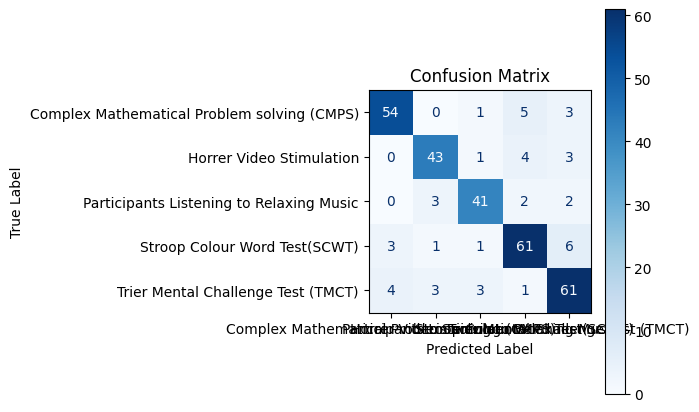

In [ ]:
ten_df = pd.read_csv("/content/drive/MyDrive/output/final_preprocessed_10.csv")
rf(ten_df)

Our new model trained on the rebalanced data provides a much better result with 84.97% accuracy.

### Checking out different number of components

We tried using different number of componenets in this datafeame. First, we tried using only 8 componenets, which yielded an ~80% accuracy for the model. Then we tried increasing the number of components, and we found that increasing the number up to a point drastically improves the accuracy. We ended up using 20 components, you can see the results here:

Accuracy: 0.928

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.91      0.98      0.95        63
                   Horrer Video Stimulation       0.90      0.88      0.89        51
   Participants Listening to Relaxing Music       1.00      0.92      0.96        48
              Stroop Colour Word Test(SCWT)       0.93      0.89      0.91        72
         Trier Mental Challenge Test (TMCT)       0.92      0.96      0.94        72

                                   accuracy                           0.93       306
                                  macro avg       0.93      0.93      0.93       306
                               weighted avg       0.93      0.93      0.93       306



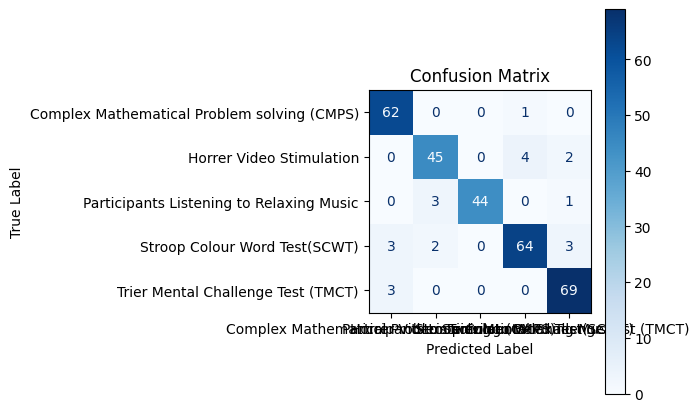

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/output/final_preprocessed_20.csv")
rf(df)

This model has a 92.81% accuracy, which is a huge increase from 84.97%. We tried with the maximum amount of components (29), which gave us a slightly better result (94%), but it's not a significant increase, so we chose the smaller dataframe that is easier to work with instead.

## SVM

In [ ]:
def svm_classifier(df):
    bandpower_cols = [col for col in df.columns if col.startswith("Brain_PC")]
    X = df[bandpower_cols].dropna()
    y = df.loc[X.index, "Scenario"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    model = make_pipeline(
        StandardScaler(),
        SVC(kernel='rbf', C=1.0, random_state=42)
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}\n")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("SVM Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

Accuracy: 0.559

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.68      0.62      0.65        63
                   Horrer Video Stimulation       0.42      0.69      0.52        51
   Participants Listening to Relaxing Music       0.68      0.52      0.59        48
              Stroop Colour Word Test(SCWT)       0.59      0.46      0.52        72
         Trier Mental Challenge Test (TMCT)       0.54      0.54      0.54        72

                                   accuracy                           0.56       306
                                  macro avg       0.58      0.57      0.56       306
                               weighted avg       0.58      0.56      0.56       306



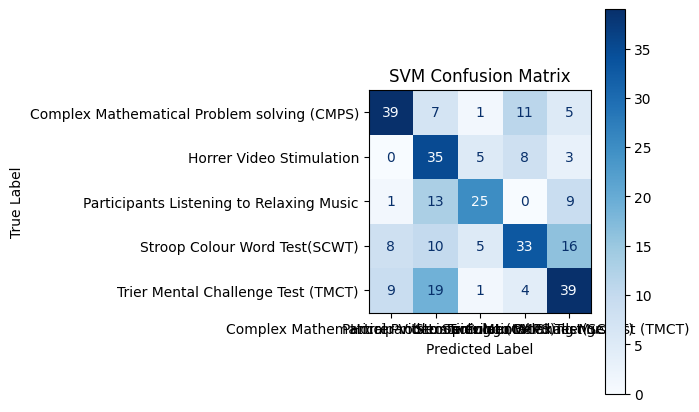

In [ ]:
svm_classifier(ten_df)

As previously, we tried out using only ten components, which gave us a model that can predict with a 55.9% accuracy. It is currently the worst so far. Now comes the dataframe with 20 components:

Accuracy: 0.663

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.73      0.75      0.74        63
                   Horrer Video Stimulation       0.43      0.71      0.53        51
   Participants Listening to Relaxing Music       0.77      0.56      0.65        48
              Stroop Colour Word Test(SCWT)       0.79      0.69      0.74        72
         Trier Mental Challenge Test (TMCT)       0.72      0.60      0.65        72

                                   accuracy                           0.66       306
                                  macro avg       0.69      0.66      0.66       306
                               weighted avg       0.70      0.66      0.67       306



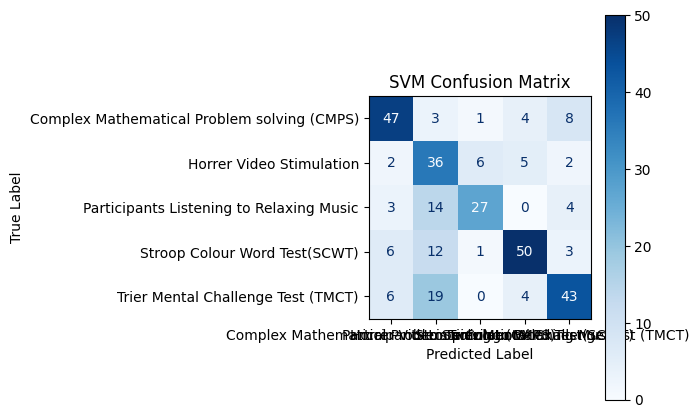

In [ ]:
svm_classifier(df)

66.3% is an improvement, but it's far from the random forest model. We can clearly see that SVM is not the method we need for our data.

## XGBoost

In [ ]:
def xgb_classifier(df):
    bandpower_cols = [col for col in df.columns if col.startswith("Brain_PC")]
    X = df[bandpower_cols].dropna()
    y = df.loc[X.index, "Scenario"]
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc,
        test_size=0.2,
        random_state=42,
        stratify=y_enc
    )

    model = XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        objective='multi:softprob',
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred_enc = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred_enc)
    print(f"Accuracy: {acc:.3f}\n")
    y_test_str = le.inverse_transform(y_test)
    y_pred_str = le.inverse_transform(y_pred_enc)

    print("Classification Report:")
    print(classification_report(y_test_str, y_pred_str))
    cm = confusion_matrix(y_test_str, y_pred_str, labels=le.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("XGBoost Confusion Matrix")
    plt.xlabel("Predicted Scenario")
    plt.ylabel("True Scenario")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:11:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.810

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.87      0.83      0.85        63
                   Horrer Video Stimulation       0.82      0.80      0.81        51
   Participants Listening to Relaxing Music       0.81      0.79      0.80        48
              Stroop Colour Word Test(SCWT)       0.80      0.79      0.80        72
         Trier Mental Challenge Test (TMCT)       0.77      0.83      0.80        72

                                   accuracy                           0.81       306
                                  macro avg       0.81      0.81      0.81       306
                               weighted avg       0.81      0.81      0.81       306



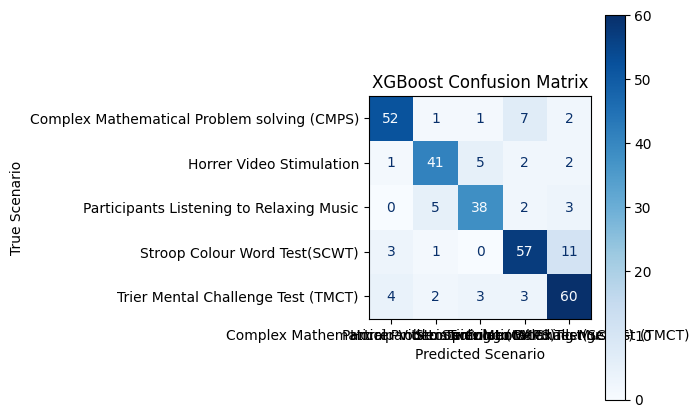

In [ ]:
xgb_classifier(ten_df)

This model using the data with 10 components gave us 81% accuracy, Random forest is still in the lead by far, but this model already beats SVM.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:11:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.902

Classification Report:
                                             precision    recall  f1-score   support

Complex Mathematical Problem solving (CMPS)       0.87      0.92      0.89        63
                   Horrer Video Stimulation       0.92      0.86      0.89        51
   Participants Listening to Relaxing Music       0.90      0.92      0.91        48
              Stroop Colour Word Test(SCWT)       0.89      0.86      0.87        72
         Trier Mental Challenge Test (TMCT)       0.94      0.94      0.94        72

                                   accuracy                           0.90       306
                                  macro avg       0.90      0.90      0.90       306
                               weighted avg       0.90      0.90      0.90       306



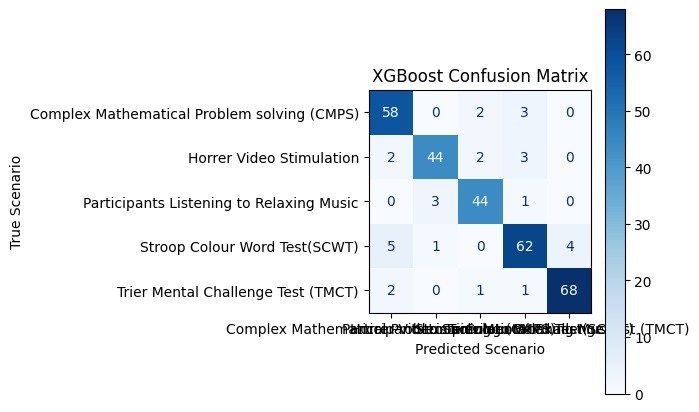

In [ ]:
xgb_classifier(df)

Our second best model so far, resulting in a 90.2% accuracy. This can already predict really accurately, but random forest is slightly better.

## Summary



*   Random Forest
  *  Most accurate model (acc: 92.8%)
  *  Strong in predicting "Listening to Relaxing Music" (f1: 96%)
  *  Weak in predicting "Horror Video Stimulation" (f1: 89%)

*   SVM
  *  Least accurate model (acc: 66.3%)
  *  Weak in predicting "Horror Video Stimulation" (f1: 53%)

*   XGBoost
  *  Close to Random Forest in accuracy (acc: 90.2%)
  *  Strong in predicting "Trier Mental Challenge Test" (f1: 94%)
  *  Weak in predicting "Stroop Colour Word Test" (f1: 87%)

# Neural Network

### Creating the model

We are going to use pyTorch for creating the neural network. It's a fairly straightforward process that will hopefully yield better results than our different classification models

In [ ]:
class ScenarioDataset(Dataset):
    def __init__(self, df):
        # select features
        feat_cols = [c for c in df.columns if c.startswith("Brain_PC")] + ["BATTERY_mean", "BATTERY_std"]
        data = df[feat_cols].dropna()
        self.X = data.values.astype(np.float32)
        y = df.loc[data.index, "Scenario"]
        self.le = LabelEncoder().fit(y)
        self.y = self.le.transform(y).astype(np.int64)

        # standardize
        self.scaler = StandardScaler().fit(self.X)
        self.X = self.scaler.transform(self.X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for in_d, out_d in zip(dims, dims[1:]):
            layers += [nn.Linear(in_d, out_d), nn.ReLU()]
        layers.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

### Training the model

In [ ]:
def train_and_evaluate(
    csv_path,
    batch_size=32,
    lr=1e-3,
    epochs=100,
    hidden_dims=[256, 128, 64, 128, 256],
    test_frac=0.2,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    df = pd.read_csv(csv_path)
    ds = ScenarioDataset(df)
    num_classes = len(ds.le.classes_)
    input_dim = ds.X.shape[1]

    test_size = int(len(ds) * test_frac)
    train_size = len(ds) - test_size
    train_ds, test_ds = random_split(ds, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    model = SimpleNN(input_dim, hidden_dims, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / train_size
        print(f"Epoch {epoch:02d} — loss: {avg_loss:.4f}")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y_batch.numpy())
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    acc = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {acc:.3f}\n")
    print("Classification Report:")
    print(classification_report(
        ds.le.inverse_transform(y_true),
        ds.le.inverse_transform(y_pred),
        digits=3
    ))

    return {
        "model": model,
        "scaler": ds.scaler,
        "label_encoder": ds.le,
        "accuracy": acc
    }

results = train_and_evaluate("/content/drive/MyDrive/output/final_preprocessed_20.csv")

Epoch 01 — loss: 1.4889
Epoch 02 — loss: 1.1798
Epoch 03 — loss: 0.9940
Epoch 04 — loss: 0.8141
Epoch 05 — loss: 0.6681
Epoch 06 — loss: 0.5227
Epoch 07 — loss: 0.4866
Epoch 08 — loss: 0.3962
Epoch 09 — loss: 0.3138
Epoch 10 — loss: 0.2865
Epoch 11 — loss: 0.2107
Epoch 12 — loss: 0.1973
Epoch 13 — loss: 0.2250
Epoch 14 — loss: 0.2665
Epoch 15 — loss: 0.1842
Epoch 16 — loss: 0.1332
Epoch 17 — loss: 0.1062
Epoch 18 — loss: 0.0842
Epoch 19 — loss: 0.0834
Epoch 20 — loss: 0.0605
Epoch 21 — loss: 0.0792
Epoch 22 — loss: 0.0554
Epoch 23 — loss: 0.0453
Epoch 24 — loss: 0.1818
Epoch 25 — loss: 0.1561
Epoch 26 — loss: 0.0552
Epoch 27 — loss: 0.0466
Epoch 28 — loss: 0.0529
Epoch 29 — loss: 0.0366
Epoch 30 — loss: 0.0283
Epoch 31 — loss: 0.0266
Epoch 32 — loss: 0.0266
Epoch 33 — loss: 0.0274
Epoch 34 — loss: 0.0272
Epoch 35 — loss: 0.0284
Epoch 36 — loss: 0.0258
Epoch 37 — loss: 0.2135
Epoch 38 — loss: 0.2141
Epoch 39 — loss: 0.1080
Epoch 40 — loss: 0.0591
Epoch 41 — loss: 0.0387
Epoch 42 — loss:

~96% accuracy is our current best, beating the 92.8% of the random forest model

In [ ]:
def save_artifacts(artifacts, out_dir="/content/drive/MyDrive/output/artifacts"):
    out_dir = Path(out_dir)
    out_dir.mkdir(exist_ok=True)

    model_path = out_dir / "scenario_model.pth"
    torch.save(artifacts["model"].state_dict(), model_path)
    print(f"Model weights saved to {model_path}")

    scaler_path = out_dir / "scaler.joblib"
    joblib.dump(artifacts["scaler"], scaler_path)
    print(f"Scaler saved to {scaler_path}")

    le_path = out_dir / "label_encoder.joblib"
    joblib.dump(artifacts["label_encoder"], le_path)
    print(f"Label encoder saved to {le_path}")

save_artifacts(results)

Model weights saved to /content/drive/MyDrive/output/artifacts/scenario_model.pth
Scaler saved to /content/drive/MyDrive/output/artifacts/scaler.joblib
Label encoder saved to /content/drive/MyDrive/output/artifacts/label_encoder.joblib


### Trying out a NN without battery

In [ ]:
class ScenarioDatasetNoBattery(Dataset):
    def __init__(self, df):
        # select only the Brain_PC* columns
        feat_cols = [c for c in df.columns if c.startswith("Brain_PC")]
        data = df[feat_cols].dropna()
        self.X = data.values.astype(np.float32)

        # label encode Scenario
        y = df.loc[data.index, "Scenario"]
        self.le = LabelEncoder().fit(y)
        self.y = self.le.transform(y).astype(np.int64)

        # standardize the PC features
        self.scaler = StandardScaler().fit(self.X)
        self.X = self.scaler.transform(self.X)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for in_d, out_d in zip(dims, dims[1:]):
            layers += [nn.Linear(in_d, out_d), nn.ReLU()]
        layers.append(nn.Linear(dims[-1], num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
def train_and_evaluate_no_battery(
    csv_path,
    batch_size=32,
    lr=1e-3,
    epochs=100,
    hidden_dims=[256, 128, 64, 128, 256],
    test_frac=0.2,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    # load data and wrap dataset
    df = pd.read_csv(csv_path)
    ds = ScenarioDatasetNoBattery(df)
    num_classes = len(ds.le.classes_)
    input_dim = ds.X.shape[1]

    # train/test split
    test_size = int(len(ds) * test_frac)
    train_size = len(ds) - test_size
    train_ds, test_ds = random_split(ds, [train_size, test_size])

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # model / loss / optimizer
    model = SimpleNN(input_dim, hidden_dims, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # training loop
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
        avg_loss = total_loss / train_size
        print(f"Epoch {epoch:02d} — loss: {avg_loss:.4f}")

    # evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(y_batch.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    acc = accuracy_score(y_true, y_pred)
    print(f"\nTest Accuracy: {acc:.3f}\n")
    print("Classification Report:")
    print(classification_report(
        ds.le.inverse_transform(y_true),
        ds.le.inverse_transform(y_pred),
        digits=3
    ))

    return {
        "model": model,
        "scaler": ds.scaler,
        "label_encoder": ds.le,
        "accuracy": acc
    }

In [ ]:
results = train_and_evaluate_no_battery("/content/drive/MyDrive/output/final_preprocessed_20.csv")

Epoch 01 — loss: 1.5315
Epoch 02 — loss: 1.2718
Epoch 03 — loss: 1.0891
Epoch 04 — loss: 0.8878
Epoch 05 — loss: 0.7860
Epoch 06 — loss: 0.6763
Epoch 07 — loss: 0.6443
Epoch 08 — loss: 0.4833
Epoch 09 — loss: 0.4111
Epoch 10 — loss: 0.3738
Epoch 11 — loss: 0.3138
Epoch 12 — loss: 0.2687
Epoch 13 — loss: 0.3530
Epoch 14 — loss: 0.2654
Epoch 15 — loss: 0.1912
Epoch 16 — loss: 0.1631
Epoch 17 — loss: 0.2478
Epoch 18 — loss: 0.1945
Epoch 19 — loss: 0.2028
Epoch 20 — loss: 0.1731
Epoch 21 — loss: 0.1130
Epoch 22 — loss: 0.1536
Epoch 23 — loss: 0.1221
Epoch 24 — loss: 0.0921
Epoch 25 — loss: 0.0793
Epoch 26 — loss: 0.1462
Epoch 27 — loss: 0.1429
Epoch 28 — loss: 0.1216
Epoch 29 — loss: 0.0859
Epoch 30 — loss: 0.0783
Epoch 31 — loss: 0.0584
Epoch 32 — loss: 0.0616
Epoch 33 — loss: 0.0571
Epoch 34 — loss: 0.0492
Epoch 35 — loss: 0.0578
Epoch 36 — loss: 0.0554
Epoch 37 — loss: 0.0663
Epoch 38 — loss: 0.0487
Epoch 39 — loss: 0.0498
Epoch 40 — loss: 0.0461
Epoch 41 — loss: 0.0440
Epoch 42 — loss: